In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.formula.api as smf
from pygam import LinearGAM, s, f, te

from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [ ]:
# Import the dataset
path_to_data = "/Users/cy027/Desktop/Master Term 3/STAT 946/Hourly_AQI_EPA.xlsb"

df = pd.read_excel(path_to_data)

# Convert the date to YYYY-MM-DD
df = df.rename(columns={'0xf': 'Date'})
df['Date'] = pd.to_datetime(
    df['Date'].astype(float),
    unit='D',
    origin='1899-12-30',
    errors='coerce'
)
# print(df.head(5))

    Date  Hour  Station ID      Station Name    CO  NO2     O3  PM2.5  SO2  \
0  44677     0       12008  Windsor Downtown  0.16  3.8  0.032    4.0  0.0   
1  44677     0       12016      Windsor West   NaN  3.2  0.031    5.0  0.9   
2  44677     0       13001           Chatham   NaN  2.4  0.031    1.0  NaN   
3  44677     0       14111            Sarnia   NaN  2.0  0.034    1.0  0.2   
4  44677     0       15020        Grand Bend   NaN  1.2  0.034    2.0  NaN   

   Max_AQI Max_AQI_Pollutant Day_Type  Season  
0      4.0             PM2.5  Weekday  Spring  
1      5.0             PM2.5  Weekday  Spring  
2      2.4               NO2  Weekday  Spring  
3      2.0               NO2  Weekday  Spring  
4      2.0             PM2.5  Weekday  Spring  
int64
0    44677
1    44677
2    44677
3    44677
4    44677
Name: Date, dtype: int64
        Date  Hour  Station ID      Station Name    CO  NO2     O3  PM2.5  \
0 2022-04-26     0       12008  Windsor Downtown  0.16  3.8  0.032    4.0   
1 2

/var/folders/st/3ggnkq754hzgx3xlt76fwgcw0000gn/T/ipykernel_15931/542284183.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


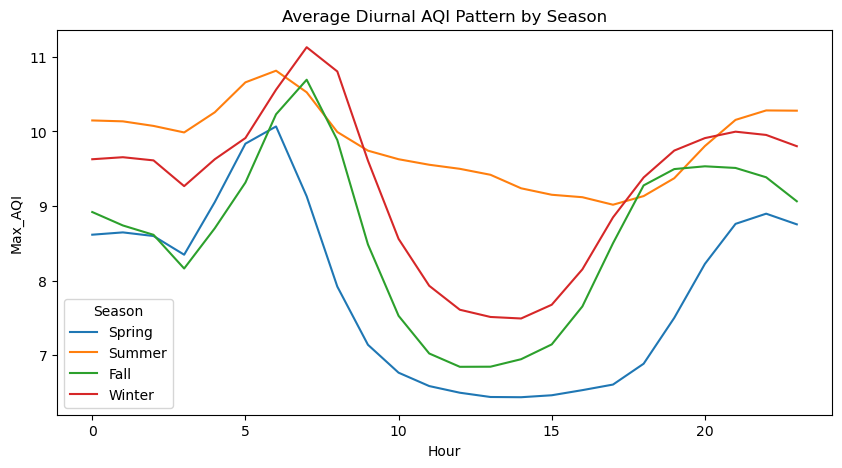

In [ ]:
plt.figure(figsize=(10, 5))
sns.lineplot(
    data=df,
    x='Hour',
    y='Max_AQI',
    hue='Season',
    ci=None
)
plt.title("Average Daily AQI Pattern by Season")
plt.show()


In [ ]:
# Model 1 (baseline model): Mixed Effects Model
df['Is_Weekend'] = (df['Day_Type'] == 'Weekend').astype(int) # weekend indicator created
lmm = smf.mixedlm(
    "Max_AQI ~ Hour + Is_Weekend + Season",
    data=df,
    groups=df["Station ID"]
)

lmm_result = lmm.fit()
print(lmm_result.summary())

           Mixed Linear Model Regression Results
Model:             MixedLM Dependent Variable: Max_AQI      
No. Observations:  802357  Method:             REML         
No. Groups:        39      Scale:              91.1734      
Min. group size:   60      Log-Likelihood:     -2949066.5135
Max. group size:   21217   Converged:          Yes          
Mean group size:   20573.3                                  
------------------------------------------------------------
                 Coef.  Std.Err.    z    P>|z| [0.025 0.975]
------------------------------------------------------------
Intercept         9.236    0.356  25.934 0.000  8.538  9.934
Season[T.Spring] -0.753    0.036 -21.036 0.000 -0.823 -0.682
Season[T.Summer]  1.225    0.033  36.919 0.000  1.160  1.290
Season[T.Winter]  0.657    0.037  17.707 0.000  0.584  0.730
Hour             -0.032    0.002 -20.718 0.000 -0.035 -0.029
Is_Weekend       -1.055    0.024 -44.671 0.000 -1.101 -1.009
Group Var         4.870    0.119    

In [18]:
# Model 2 (inference model): GAM with nonlinear interactions
df['Season'] = df['Season'].astype('category')
df['Season_Code'] = df['Season'].cat.codes
df['Station Name'] = df['Station Name'].astype('category')
df['Station_Code'] = df['Station Name'].cat.codes

X = df[['Hour', 'Season_Code', 'Is_Weekend', 'Station_Code']].values
y = df['Max_AQI'].values

gam = LinearGAM(
    s(0, n_splines=24) +          # nonlinear hour effect
    te(0, 1, n_splines=[24, 4]) + # hour × season interaction
    f(2) +                       # weekend effect
    f(3)                         # station fixed effect
)

gam.fit(X, y)
gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                    107.5358
Link Function:                     IdentityLink Log Likelihood:                              -2945657.0824
Number of Samples:                       802357 AIC:                                          5891531.2364
                                                AICc:                                         5891531.2661
                                                GCV:                                               90.4691
                                                Scale:                                              9.5104
                                                Pseudo R-Squared:                                    0.066
Feature Function                  Lam

/var/folders/st/3ggnkq754hzgx3xlt76fwgcw0000gn/T/ipykernel_15931/3566173192.py:18: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()


In [24]:
# Station specific daily pattern by mixed effect model
from patsy import dmatrix

# Create spline basis for hour
hour_spline = dmatrix(
    "bs(Hour, df=6, degree=3, include_intercept=False)",
    df,
    return_type='dataframe'
)

df = pd.concat([df, hour_spline], axis=1)

import statsmodels.formula.api as smf

formula = """
Max_AQI ~ 
bs(Hour, df=6, degree=3) +
C(Season) +
C(Day_Type)
"""

model = smf.mixedlm(
    formula,
    df,
    groups=df["Station ID"]
)

result = model.fit()
print(result.summary())

                 Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     Max_AQI      
No. Observations:     802357      Method:                 REML         
No. Groups:           39          Scale:                  90.6143      
Min. group size:      60          Log-Likelihood:         -2946601.9746
Max. group size:      21217       Converged:              Yes          
Mean group size:      20573.3                                          
-----------------------------------------------------------------------
                            Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------
Intercept                    9.465    0.358  26.454 0.000  8.764 10.167
C(Season)[T.Spring]         -0.753    0.036 -21.102 0.000 -0.823 -0.683
C(Season)[T.Summer]          1.225    0.033  37.043 0.000  1.160  1.290
C(Season)[T.Winter]          0.657    0.037  17.754 0.000  0.584  0.729
C(Day_Typ

In [27]:
features = [
    'Hour', 'Is_Weekend', 'Season_Code', 'Station_Code',
    'CO', 'NO2', 'O3', 'PM2.5', 'SO2'
]

X_ml = df[features]
y_ml = df['Max_AQI']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_ml, y_ml, test_size=0.2, random_state=42
)

# Fit model
xgb = XGBRegressor(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb.fit(X_train, y_train)

preds = xgb.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, preds))
print(f"XGBoost RMSE: {rmse:.4f}")

XGBoost RMSE: 3.4912


In [21]:
'''We first establish baseline temporal effects using mixed-effects linear models with station-level random intercepts. To relax linearity and separability assumptions, we then employ generalized additive models with tensor-product smooths to capture nonlinear diurnal–seasonal interactions. Finally, a tree-based ensemble model is fitted to assess predictive performance and complex interactions beyond parametric assumptions.'''

'We first establish baseline temporal effects using mixed-effects linear models with station-level random intercepts. To relax linearity and separability assumptions, we then employ generalized additive models with tensor-product smooths to capture nonlinear diurnal–seasonal interactions. Finally, a tree-based ensemble model is fitted to assess predictive performance and complex interactions beyond parametric assumptions.'